# Week 5 - Project 1
## Josh Iden  
### 2/21/23

Presentation: [https://youtu.be/8xnHrOr8lLs]('https://youtu.be/8xnHrOr8lLs')

![](PROJECT_1.png)

## Introduction  

This project began by looking at the **Social Network: MOOC User Action Dataset** data compiled by the Stanford Network Analysis Project (SNAP). A little bit about this dataset,

Source: [https://snap.stanford.edu/data/act-mooc.html](https://snap.stanford.edu/data/act-mooc.html)

From dataset documentation:

*The MOOC user action dataset represents the actions taken by users on a popular MOOC platform. The actions are represented as a directed, temporal network. The nodes represent users and course activities (targets), and edges represent the actions by users on the targets. The actions have attributes and timestamps. To protect user privacy, we anonimize the users and timestamps are standardized to start from timestamp 0. The dataset is directed, temporal, and attributed.*

*Additionally, each action has a binary label, representing whether the user dropped-out of the course after this action, i.e., whether this is last action of the user.*

This analysis was to focus on the hypothetical outcome, can degree centrality be used to predict the total number of actions taken before dropping out of the course. 

## The Data

The dataset contained three files:  

**mooc_actions.tsv**, 	*Time-ordered sequence of user actions.*  
**mooc_action_features.tsv**,  	*Features associated with each action.*  
**mooc_action_labels.tsv**, 	*Binary label associated with each action, indicating whether the student drops-out after the action.*  

## Outcome  

Upon investigation, this dataset proved unsuitable for the intended analysis, as the nodes were not connected. 

## Introduction - New Dataset  

Moving along, I decided to take a look at the [Bitcoin Alpha Trust Network Data](https://snap.stanford.edu/data/soc-sign-bitcoin-alpha.html). From the dataset documentation:

*This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin Alpha. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin Alpha rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.*

## The Data

The dataset consists of 1 file, each line containing data in the following format:

`SOURCE, TARGET, RATING, TIME`  

Where,

`SOURCE`: node id of source, ie rater  
`TARGET`: node id of target, ie ratee  
`RATING`: the source's rating for the target, ranging from -10 to +10 in steps of 1  
`TIME`: the time of the rating, measured as seconds since Epoch

This analysis will focus on the question, does degree centrality have an effect on trust rating?

One of the challenges I've encountered with my analysis is the size of the datasets being computationally expensive to work with, so for the purpose of this analysis, I will trim the data to a more manageable size. 

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
%matplotlib inline

fp = 'soc-sign-bitcoinalpha.csv'
df = pd.read_csv(fp, header=None, names=['SOURCE','TARGET','RATING','TIME'])

df.head()

,SOURCE,TARGET,RATING,TIME
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400


In [2]:
df.describe()

,SOURCE,TARGET,RATING,TIME
count,24186.000000,24186.000000,24186.000000,2.418600e+04
mean,864.029314,1051.093815,1.463946,1.347099e+09
std,1592.085638,1871.765504,2.903656,3.397039e+07
min,1.000000,1.000000,-10.000000,1.289192e+09
25%,58.000000,66.000000,1.000000,1.312690e+09
50%,238.000000,279.000000,1.000000,1.345435e+09
75%,898.000000,1068.000000,2.000000,1.369454e+09
max,7604.000000,7604.000000,10.000000,1.453439e+09


We can take a quick look at the distribution of ratings, 

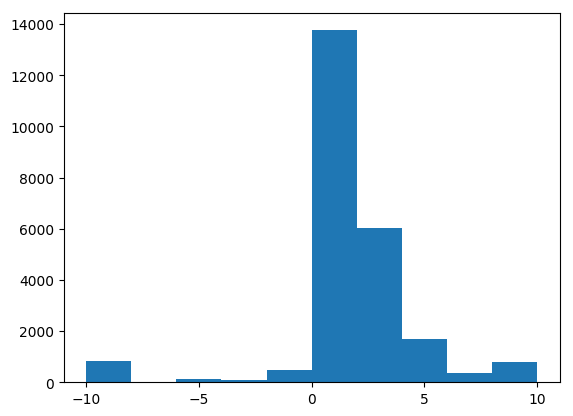

In [3]:
plt.hist(df.RATING)
plt.xticks(np.arange(-10, 15, step=5));

We can see the ratings are very skewed and generally fall between zero and 1. Let's trim the data and see if we can retain this distribution of ratings. 

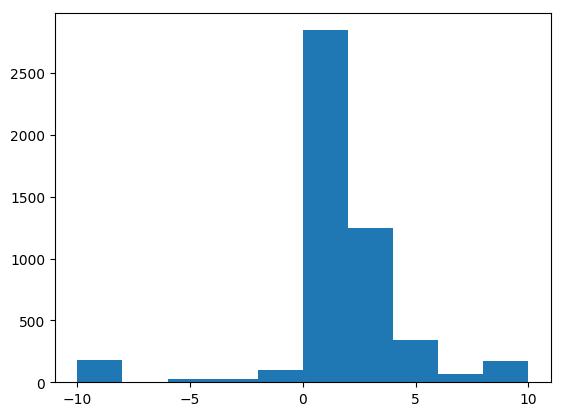

In [4]:
random.seed(10)

df1 = df.iloc[:,:3].sample(5000)
plt.hist(df1.RATING)
plt.xticks(np.arange(-10, 15, step=5));

Looks pretty good! Let's move on and create an edgelist from the dataframe.

In [5]:
# read the dataframe into a graph object
G = nx.from_pandas_dataframe(df1, 'SOURCE', 'TARGET', edge_attr='RATING', create_using=nx.DiGraph())
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 2321
Number of edges: 5000
Average in degree:   2.1542
Average out degree:   2.1542


We can draw a basic graph of the network, and get this "hairball" back that we can't make much inference from, other than there are a lot of nodes.

/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/joshiden/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future 

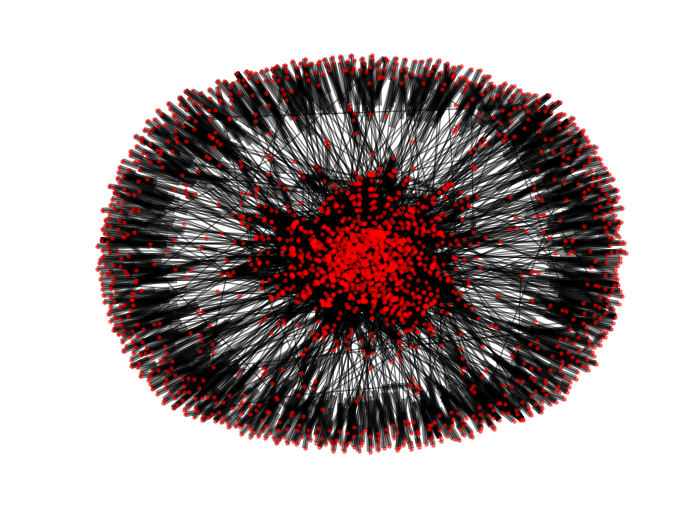

In [6]:
# this code worked until my package dependencies updated, now its breaking
nx.draw(G, node_size=5, alpha=0.5);

There's a great concept that was included in the [Network Analysis Made Simple](https://pyvideo.org/scipy-2019/network-analysis-made-simple.html) video to return the number of "unrequited friendships", ie, nodes that are not edges to any of their edges. For this analysis, this represents number of nodes that did not rate a node that rated it. 

In [7]:
unrequited = len([(n1, n2) for n1, n2 in G.edges() if not G.has_edge(n2, n1)])
unrequited

4146

There are 4110 unrequited edges. So we know that the graph is directed. Now let's find the degree centrality and eigenvector centrality and store this information in a dataframe.

In [8]:
source_rating = df1.groupby('SOURCE')['RATING'].mean().to_frame('SOURCE_RATING').reset_index()
target_rating = df1.groupby('TARGET')['RATING'].mean().to_frame('TARGET_RATING').reset_index()
node = pd.merge(source_rating, target_rating, left_on='SOURCE', right_on='TARGET')
node = node.loc[:,['SOURCE','SOURCE_RATING','TARGET_RATING']].rename(columns={'SOURCE':'NODE'})
node.head()

,NODE,SOURCE_RATING,TARGET_RATING
0,1,1.234234,1.961538
1,2,2.450000,2.847826
2,3,1.804348,2.923077
3,4,2.192308,3.468750
4,5,0.085714,2.851852


For each node, we want to their degree centrality and eigenvector centrality.

In [9]:
degree = nx.degree(G)
degree_df = pd.DataFrame.from_dict(degree, orient='index').reset_index().rename(columns={'index':'NODE', 0:'DEGREE_CENTRALITY'})
degree_df.head()

,NODE,DEGREE_CENTRALITY
0,7,82
1,1171,2
2,1025,3
3,117,22
4,4,84


In [10]:
eigen = nx.nx.eigenvector_centrality_numpy(G)
eigen_df = pd.DataFrame.from_dict(eigen, orient='index').reset_index().rename(columns={'index':'NODE', 0:'EIGEN_CENTRALITY'})
eigen_df.head()

,NODE,EIGEN_CENTRALITY
0,7,0.114391
1,1171,0.022626
2,1025,0.007774
3,117,0.032808
4,4,0.086345


Now we combine the three dataframes to one master dataframe.

In [11]:
centrality = pd.merge(degree_df, eigen_df, on='NODE')
master = pd.merge(node, centrality, on='NODE', how='left')
master.head()

,NODE,SOURCE_RATING,TARGET_RATING,DEGREE_CENTRALITY,EIGEN_CENTRALITY
0,1,1.234234,1.961538,215,0.188338
1,2,2.450000,2.847826,86,0.168063
2,3,1.804348,2.923077,98,0.166079
3,4,2.192308,3.468750,84,0.086345
4,5,0.085714,2.851852,62,0.086962


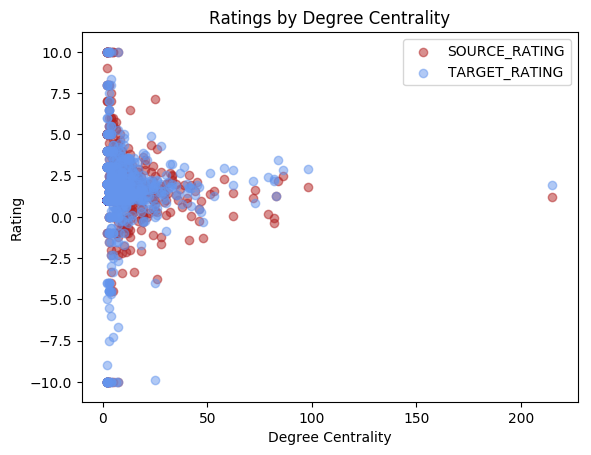

In [12]:
plt.scatter(master.DEGREE_CENTRALITY, master.SOURCE_RATING, color='firebrick', alpha=0.5)
plt.scatter(master.DEGREE_CENTRALITY, master.TARGET_RATING, color='cornflowerblue', alpha=0.5)
plt.legend()
plt.title("Ratings by Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Rating")
plt.show()

We can see that the higher the degree centrality, the likelier both the source and target ratings are between 0 and 3. We can observe this to imply that frequent users, ones who are most connected, are less likely to give or receive excessively high or excessively low ratings. Concordantly, less frequent users are more likely to *receive* higher or lower ratings. One of the problems with this graphic, however, is that it is only looking at *average* rating, and nodes with lower degree centrality have probably given and received fewer ratings. 

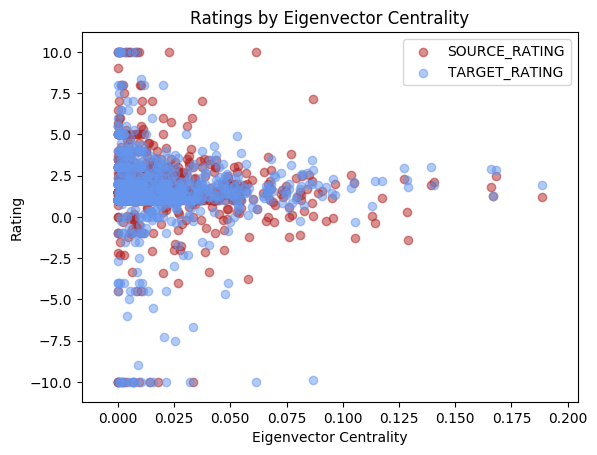

In [13]:
plt.scatter(master.EIGEN_CENTRALITY, master.SOURCE_RATING, color='firebrick', alpha=0.5)
plt.scatter(master.EIGEN_CENTRALITY, master.TARGET_RATING, color='cornflowerblue', alpha=0.5)
plt.legend()
plt.title("Ratings by Eigenvector Centrality")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Rating")
plt.show()

The eigenvector centrality gives us a slightly more useful insight, as we can see the relative importance of some of the nodes at low and high end of the ratings. Still, we see that the more active a node is, the more it's average rating falls within the 0 to 3 range. 

## Conclusion  

The conclusion here is that the eigenvector centrality is a more useful measure of which nodes have a wider reaching influence than degree centrality. It's also challenging to draw a conclusion using an average rating score because the most active and influential nodes are likeliest to have their high or low scores minimized by the average. The larger takeaway for this project is the importance of selecting an appropriate network model and metrics in order to perform a best analysis. 